In [1]:
#%% Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

import annotation, image_render, hyspec_io

In [2]:
# Paths
hyspec_file_Rrs = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Transect1-15m-AGL/R_rs/manual_Pika_L_13-14-radiance-AppendCube-SpatialCrop-ReflectivityConversionFromRadiance.bip.hdr'
annotation_json = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/label_classes.json'
annotation_png = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/transect1_15mAGL_rgb.png'

new_annotation_png = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/transect1_15mAGL_rgb_refined.png'
new_class_dict_json = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/refined_label_classes.json'

In [3]:
# Read hyperspectral file
(im,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(hyspec_file_Rrs)

In [4]:
# Limit data to visible range
vis_wl_ind = wl < 750
im = im[:,:,vis_wl_ind]
wl = wl[vis_wl_ind]
(nLines,nSamp,nWl) = im.shape

In [5]:
# Read annotation
class_dict = annotation.read_hasty_metadata(annotation_json)
annotation_mask = np.flip(skimage.io.imread(annotation_png),(0,1)) # Annotation image is flipped, flip back

In [6]:
#%% Print class dictionary
print('Class : Index \n')
for key,value in class_dict.items():
    print(key + ' : ' + str(value))

Class : Index 

Seagrass-0-25%-density : 1
Seagrass-25-50%-density : 2
Fucus-vesiculosus : 3
Ascophyllum-nodosum : 4
Sand : 5
White-rope : 6
Bamboo-stick : 7
Blue-marker : 8
Yellow-marker : 9
Gray-reference : 10
Black-reference : 11
Shadow : 12


In [7]:
#%% Create mask which only indicates seagrass (both classes combined)
seagrass_mask = np.zeros(annotation_mask.shape,dtype=np.bool_)
seagrass_class_names = ['Seagrass-0-25%-density','Seagrass-25-50%-density']
for name in seagrass_class_names:
    seagrass_mask = seagrass_mask | (annotation_mask == class_dict[name])

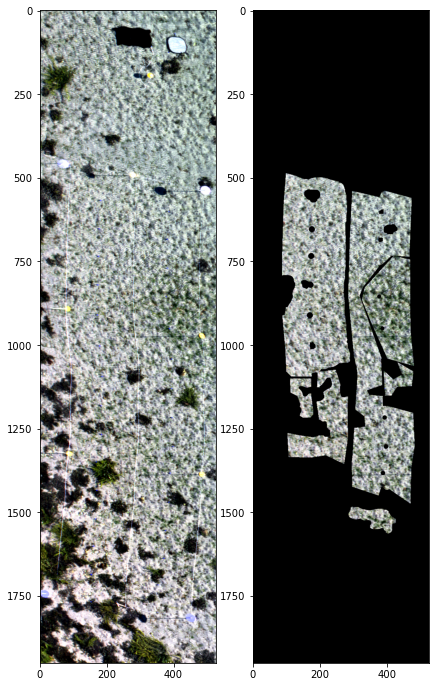

In [8]:
# Show RGB render of whole hyperspetral image, and image with seagrass mask
fig,ax = plt.subplots(ncols=2,figsize=(7,12))
ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(im[:,:,rgb_ind])*np.expand_dims(seagrass_mask,axis=2))

plt.show()

In [9]:
# Extract seagrass spectra, implicit conversion to 2D matrix
X = im[seagrass_mask]
X.shape

(279484, 115)

In [10]:
# Create pipeline for band-wise normalization and PCA, and k-means clustering
pipe = make_pipeline(StandardScaler(),PCA(n_components=5)) 

In [11]:
# Fit and transform to PCA coordinates
X_pca = pipe.fit_transform(X)

In [12]:
# Use k-means to cluster data into two classes (assumed: sand and seagrass)
kmeans = KMeans(n_clusters=2,random_state=0)
seagrass_cluster_labels = kmeans.fit_predict(X_pca) + 1  # Add 1 to separate from background (0)

In [13]:
# Insert cluster classes into image for interpretation
seagrass_cluster_im = np.zeros(im.shape[0:2])
seagrass_cluster_im[seagrass_mask] = seagrass_cluster_labels

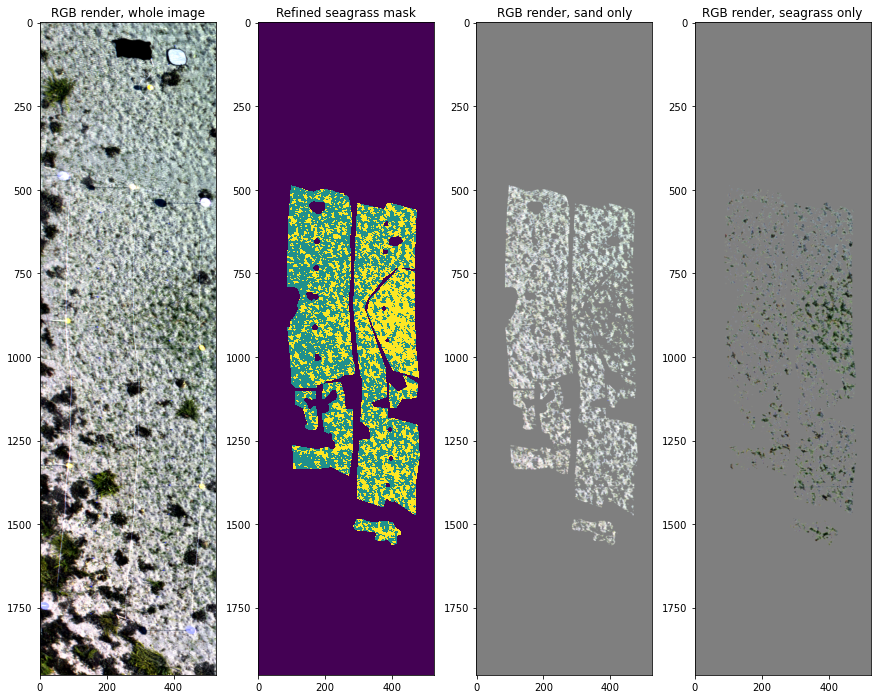

In [14]:
# Show RGB render of whole hyperspetral image, and image with seagrass mask
rgb_im = image_render.percentile_stretch(im[:,:,rgb_ind])
sand_im = 0.5*np.ones(rgb_im.shape)
sand_im[seagrass_cluster_im == 1] = rgb_im[seagrass_cluster_im == 1]
seagrass_im = 0.5*np.ones(rgb_im.shape)
seagrass_im[seagrass_cluster_im == 2] = rgb_im[seagrass_cluster_im == 2]

fig,ax = plt.subplots(ncols=4,figsize=(15,12))
ax[0].imshow(rgb_im)
ax[0].set_title('RGB render, whole image')
ax[1].imshow(seagrass_cluster_im,interpolation='none',cmap='viridis')
ax[1].set_title('Refined seagrass mask')
ax[2].imshow(sand_im)
ax[2].set_title('RGB render, sand only')
ax[3].imshow(seagrass_im)
ax[3].set_title('RGB render, seagrass only')

plt.show()

In [15]:
# Create new class dictionary (seagrass classes combined)
new_class_dict = {'Sand': 1, 
                  'Zostera-marina': 2,
                  'Ascophyllum-nodosum': 3,
                  'Fucus-vesiculosus': 4}

In [16]:
# Create new class mask
new_class_mask = np.zeros(annotation_mask.shape)

# Merge original "sand" class with one of the clusters from the seagrass areas
new_class_mask[(annotation_mask == class_dict['Sand']) | (seagrass_cluster_im == 1)] = new_class_dict['Sand']

# The second cluster from the seagrass areas corresponds to a refined seagrass map
new_class_mask[(seagrass_cluster_im == 2)] = new_class_dict['Zostera-marina']

# Copy rockweed classes unchanged
new_class_mask[annotation_mask == class_dict['Ascophyllum-nodosum']] = new_class_dict['Ascophyllum-nodosum']
new_class_mask[annotation_mask == class_dict['Fucus-vesiculosus']] = new_class_dict['Fucus-vesiculosus']

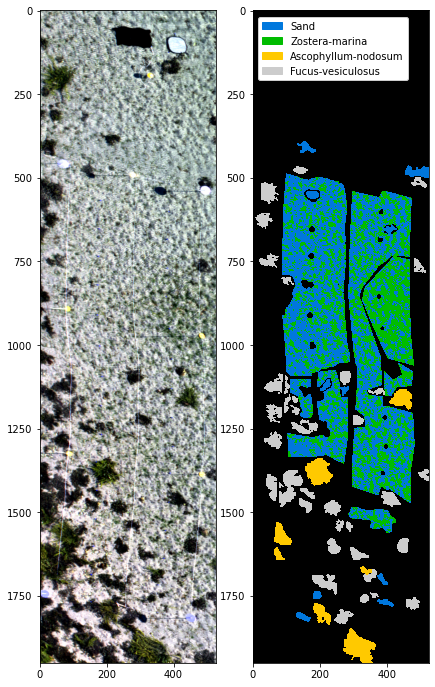

In [17]:
# Show RGB render of hyperspetral image and refined annotation mask
fig,ax = plt.subplots(ncols=2,figsize=(7,12))
ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
cl_im = ax[1].imshow(new_class_mask,interpolation='none',cmap='nipy_spectral')

# Create classification plot legend
import matplotlib.patches as mpatches
values = np.arange(len(new_class_dict))+1
colors = [cl_im.cmap(cl_im.norm(value)) for value in values]
legend_class_names = list(new_class_dict.keys())

patches = [ mpatches.Patch(color=colors[i], label=legend_class_names[i] ) for i in range(len(values)) ]
ax[1].legend(handles=patches, bbox_to_anchor=(0.03, 0.99), loc=2, borderaxespad=0., framealpha=1 )

plt.show()

In [18]:
# Save new class mask as PNG file
annotation.save_class_mask(new_class_mask,new_annotation_png)

In [19]:
# Save new class dictionary
annotation.save_class_dict(new_class_dict,new_class_dict_json)

In [20]:
# Try loading saved dictionary
read_json_class_data = annotation.read_class_dict(new_class_dict_json)

In [21]:
read_json_class_data

{'Sand': 1,
 'Zostera-marina': 2,
 'Ascophyllum-nodosum': 3,
 'Fucus-vesiculosus': 4}